In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
# Controlla la disponibilità della GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carica il dataset CIFAR-10
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Autoencoder


Gli autoencoder sono una classe di reti neurali utilizzate nel campo del representation learning. Questi modelli prendono in input un insieme di dati, li trasformano in una nuova rappresentazione, detta rappresentazione latente, e poi cercano di ricostruire l'input originale. Gli autoencoder sono ampiamente utilizzati per la riduzione della dimensionalità, la compressione dei dati, la denoising e la data agumentation.

Gli ingredienti principali di un Autoencoder sono l'encoder, una rete che mappa l'input nella rappresentazione latente, ed il decoder, una rete che trasforma la rappresentazione latente nell'input "riccostruito".

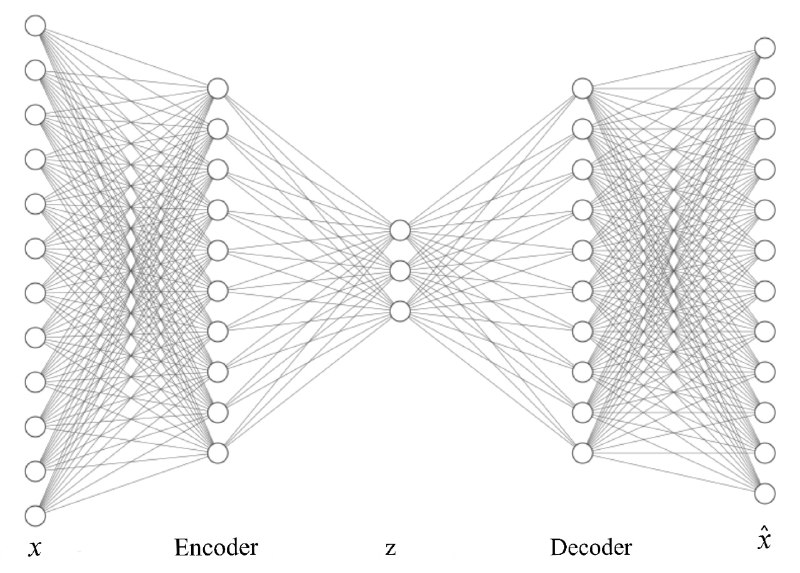

In generale, gli autoencoder si addestrano minimizzando il reconstruction error:
$$L(\theta)=(x-\hat{x})^2$$

Cosrtuiremo un autoencoder convoluzionale, il encoder è una rete neurale convoluzionale standard, per il decoder useremo dei layer convoluzionali trasposti.

L'operazione **convoluzionale trasposta** è una ccovoluzionale modificata per assomigliare ad una inversa. A differenza della convoluzionale standard che tende a diminuire le dimensioni spaziali dell'input, la convoluzionale trasposta le aumenta.

In [3]:
# Definisce l'architettura del modello
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 3, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [5]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           9,248
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
   ConvTranspose2d-7           [-1, 32, 16, 16]           9,248
              ReLU-8           [-1, 32, 16, 16]               0
   ConvTranspose2d-9           [-1, 32, 32, 32]           9,248
             ReLU-10           [-1, 32, 32, 32]               0
           Conv2d-11            [-1, 3, 32, 32]             867
          Sigmoid-12            [-1, 3, 32, 32]               0
Total params: 29,507
Trainable params: 29,507
Non-trainable params: 0
---------------------------------

In [6]:
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        images, _ = data
        images = images.to(device) 
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images) #Calcoliamo il reconstruction error
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss/len(train_loader)))



Epoch [1/50], Loss: 0.0159
Epoch [2/50], Loss: 0.0065
Epoch [3/50], Loss: 0.0053
Epoch [4/50], Loss: 0.0045
Epoch [5/50], Loss: 0.0041
Epoch [6/50], Loss: 0.0039
Epoch [7/50], Loss: 0.0037
Epoch [8/50], Loss: 0.0036
Epoch [9/50], Loss: 0.0034
Epoch [10/50], Loss: 0.0033
Epoch [11/50], Loss: 0.0032
Epoch [12/50], Loss: 0.0032
Epoch [13/50], Loss: 0.0031
Epoch [14/50], Loss: 0.0030
Epoch [15/50], Loss: 0.0030
Epoch [16/50], Loss: 0.0029
Epoch [17/50], Loss: 0.0028
Epoch [18/50], Loss: 0.0028
Epoch [19/50], Loss: 0.0028
Epoch [20/50], Loss: 0.0027
Epoch [21/50], Loss: 0.0027
Epoch [22/50], Loss: 0.0027
Epoch [23/50], Loss: 0.0026
Epoch [24/50], Loss: 0.0026
Epoch [25/50], Loss: 0.0026
Epoch [26/50], Loss: 0.0026
Epoch [27/50], Loss: 0.0025
Epoch [28/50], Loss: 0.0025
Epoch [29/50], Loss: 0.0025
Epoch [30/50], Loss: 0.0025
Epoch [31/50], Loss: 0.0024
Epoch [32/50], Loss: 0.0024
Epoch [33/50], Loss: 0.0024
Epoch [34/50], Loss: 0.0024
Epoch [35/50], Loss: 0.0024
Epoch [36/50], Loss: 0.0024
E

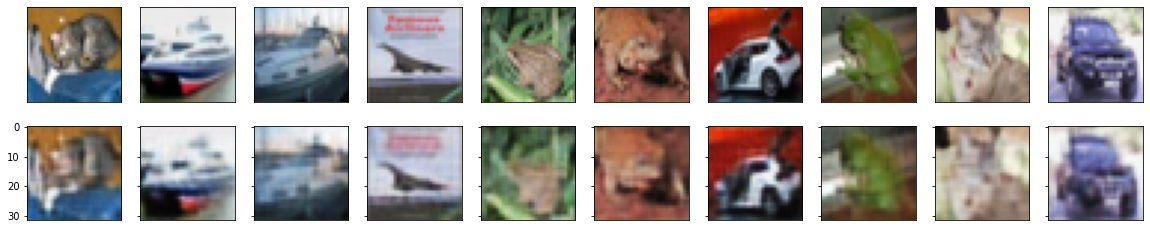

In [7]:
# Esegue il modello su alcuni dati di test sulla GPU
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device) # sposta i dati sulla GPU
outputs = model(images)

# Sposta i dati di output sulla CPU per la visualizzazione
outputs = outputs.cpu()

# Visualizza alcuni esempi di input e output del modello
n = 10
fig, axes = plt.subplots(nrows=2, ncols=n, sharex=True, sharey=True, figsize=(20, 4))

for i in range(n):
    # Input
    ax = axes[0][i]
    ax.imshow(images[i].cpu().numpy().transpose(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Output del modello
    ax = axes[1][i]
    ax.imshow(outputs[i].detach().numpy().transpose(1,2,0))
    ax.get_xaxis().set_visible(False)
   

## Unsupervised learning of geometrical features from images by explicit group actions enforcement

Francesco Calisto, Luca Bottero, Valerio Pagliarino

https://openreview.net/forum?id=sEn61s0M1hy

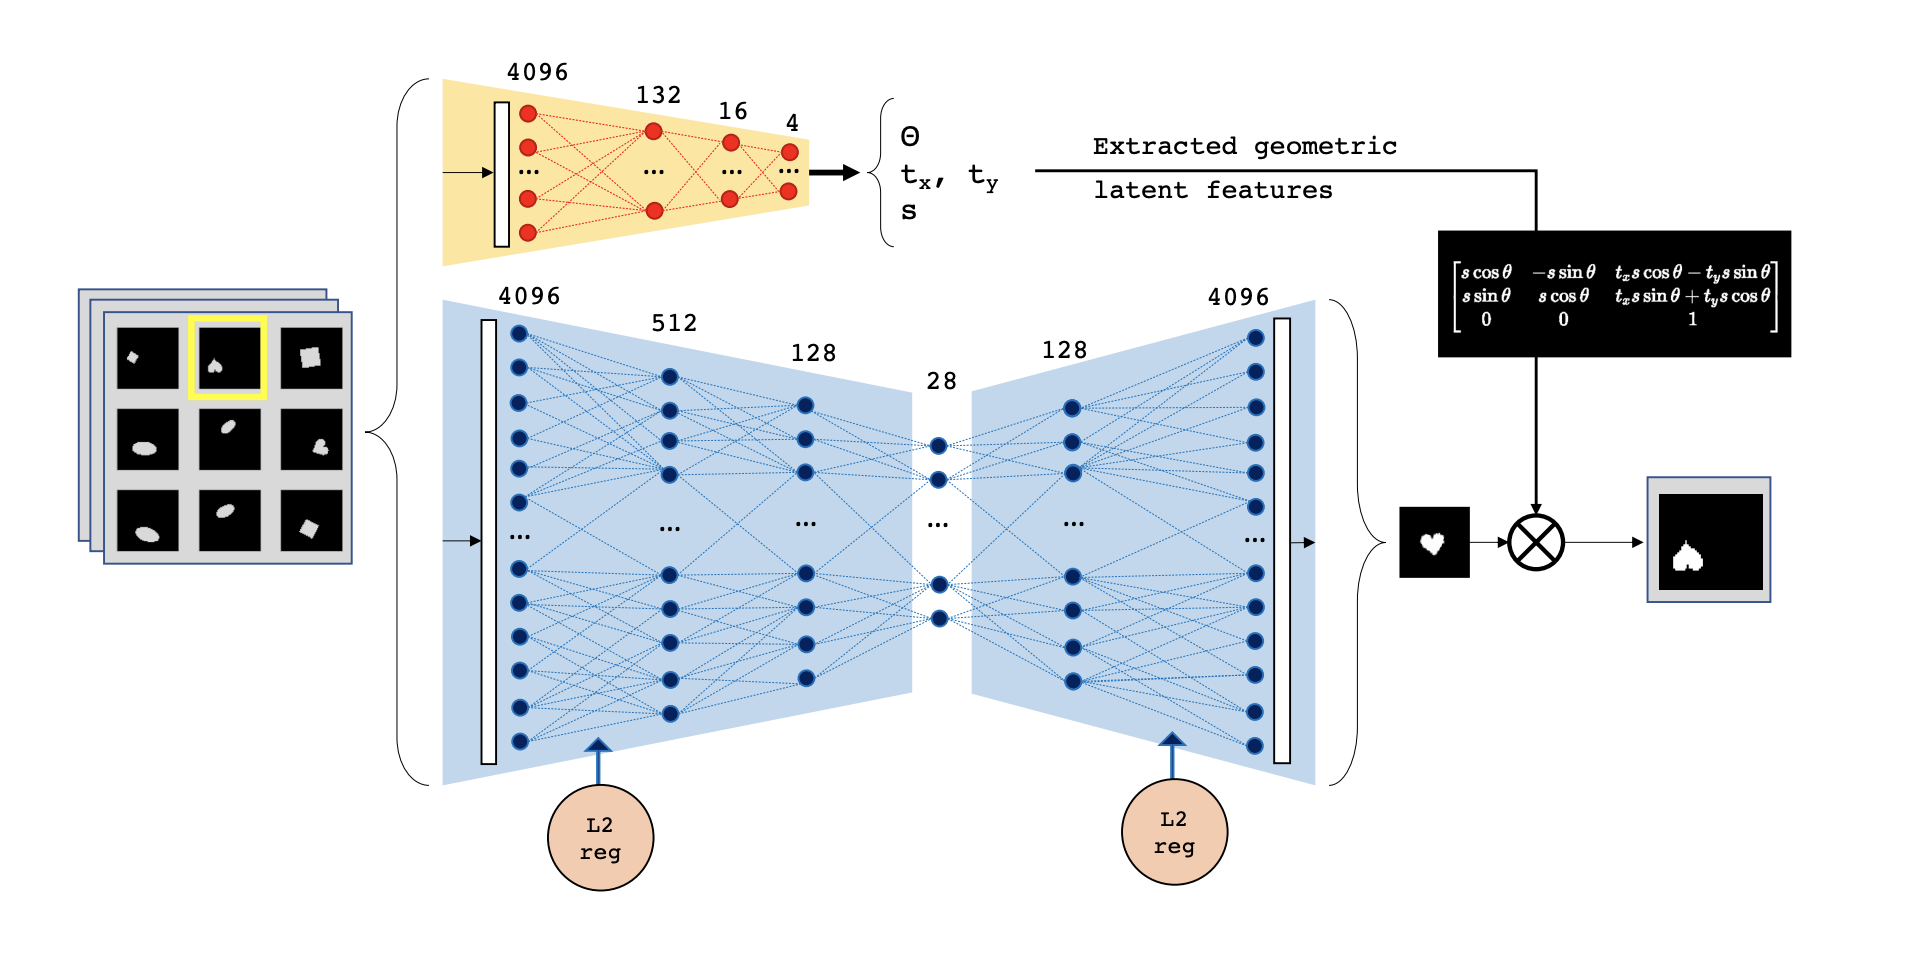

## Variational Autoencoders:


Nei [variational autoencoders](https://arxiv.org/abs/1312.6114) la rappresentazione latente viene fissata ad una distribuzione di probabilità "easy-to-model". Quest'ultima può essere poi usata per campionare nuovi dati con caratteristiche simili a quelli visti dal modello durante l'addestramento.

Esempio autoencoder variazionale gaussiano:

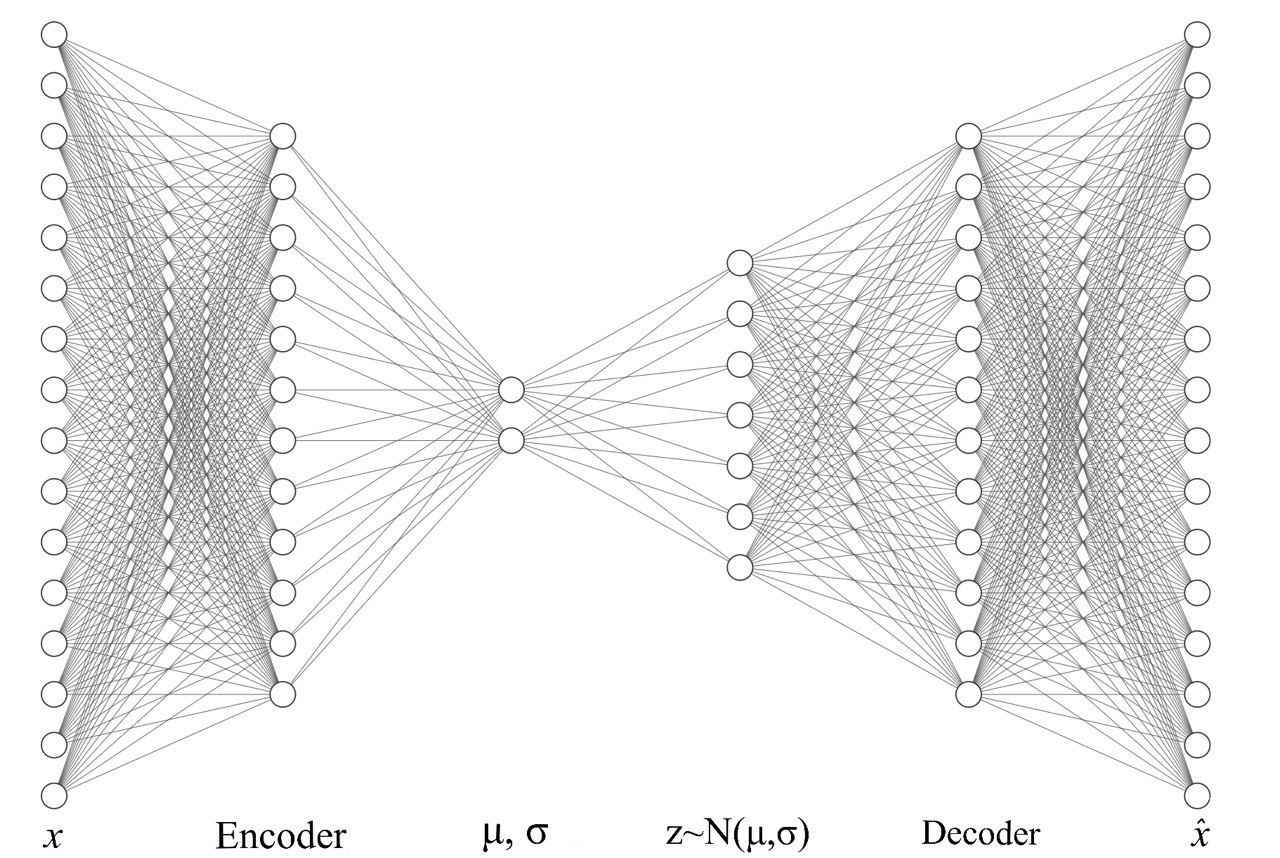

# Modelli Generativi Prondi

I modelli generativi profondi sono una classe di algoritmi di machine learning utilizzati per generare nuovi dati. Questi modelli utilizzano reti neurali profonde, per apprendere la struttura dei dati di addestramento e generare nuovi campioni che presentano caratteristiche simili. I modelli generativi profondi sono ampiamente utilizzati in diverse applicazioni, come la generazione di immagini, testo, suoni e video, e stanno diventando sempre più importanti per l'intelligenza artificiale e il machine learning.

Alcuni dei modelli generativi profondi più famosi sono:

* **Generative Adversarial Network (GAN):** questa architettura è composta da almeno due reti neurali, una generatrice e un discriminante, che lavorano insieme per generare dati verosimili. [Tutorial DCGAN](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

* **Variational Autoencoder (VAE):** [Vector Quantised Variational AutoEncoder ](https://arxiv.org/pdf/1711.00937.pdf)

* **Flow-based models:** questi modelli utilizzano una serie di trasformazioni invertibili e differenziabili per generare nuovi dati e stimare densita di probabilità.

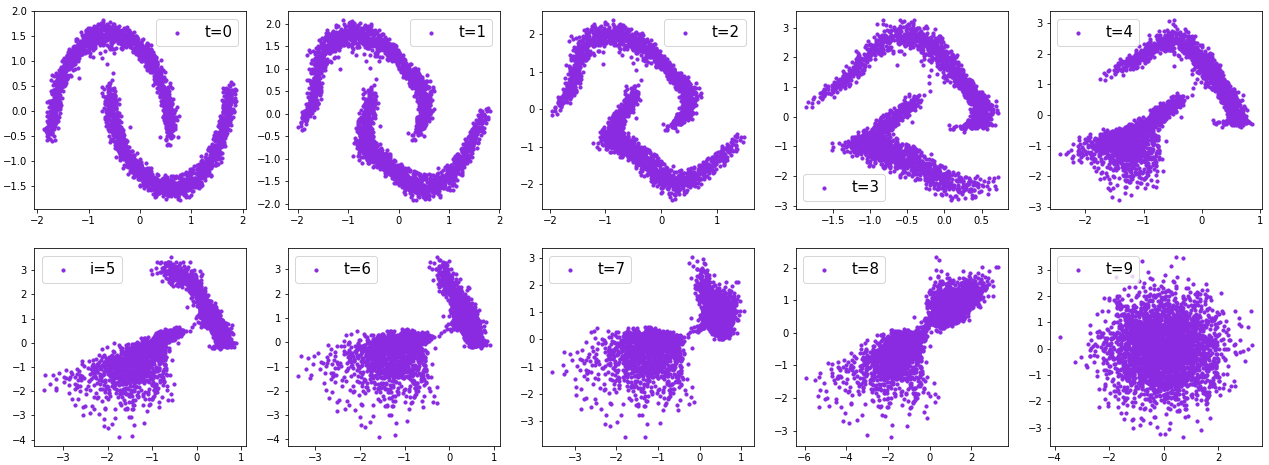

Applicati in computer vision: [RealNVP](https://arxiv.org/abs/1605.08803), [Glow](https://arxiv.org/abs/1807.03039). [Tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html)

NF in fisica: 


1.   [Introduction to Normalizing Flows for Lattice Field Theory](https://arxiv.org/abs/2101.08176)
2.   [Boltzmann generators: Sampling equilibrium states of many-body systems with deep learning](https://www.science.org/doi/10.1126/science.aaw1147)


* **Transformer-based models:** basati sulla famiglia di modelli ["Transformer"](https://arxiv.org/abs/1706.03762), utilizzano il meccanismo dell'"attention" e strutture autoregressive per imparare relazioni tra parole e generare testo coerente e plausibile. Alcuni esempi sono [Alphafold](https://www.deepmind.com/research/highlighted-research/alphafold) di Google Deepmind e [ChatGPT](https://openai.com/blog/chatgpt) di Open AI. [Tutorial NLP](https://pytorch.org/tutorials/beginner/transformer_tutorial.html), [Tutorial Computer Vision](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html)


* **Diffusion Probabilistic Models:** Algoritmi ispirati alla termodinamicca del disequilibrio. I campioni vengono trasformati in rumore usando un processo stocastico, parallelamente il modello impara il processo reverso così da ricostruire i dati a partire dal rumore. ES: [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf)